### Exercice 3: personnal recommendations

#### (a) Add some personnal ratings for at least 10 movies in the ratings dataframe.

In [1]:
from surprise import prediction_algorithms
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np

# Read datas from disk
data_movie = pd.read_csv("D:/Mines_Ales/S9/recommander_sys/movies.csv")
data_rating = pd.read_csv("D:/Mines_Ales/S9/recommander_sys/ratings.csv")

# Making some random rating for 10 movies
movie_rating = (np.random.randint(0,5,size=10)).reshape((10,1))
movie_id = np.array([1,3,6,47,50,193581,193583,193585,193587,193609]).reshape((10,1))
user_id = (np.ones(10)*1000000).reshape((10,1))
timestamp = (np.ones(10)*(round(time.time()))).reshape((10,1))

# Concate two dataframe to one, adding new rating to orgrinal data
my_rating = np.concatenate((user_id, movie_id, movie_rating, timestamp), axis=1)
my_rating = pd.DataFrame(my_rating, columns=['userId', 'movieId', 'rating', 'timestamp'])
data_rating_new = pd.concat([data_rating,my_rating], axis=0).reset_index()

# show the whole new rating set
data_rating_new

,index,userId,movieId,rating,timestamp
0,0,1.0,1.0,4.0,9.649827e+08
1,1,1.0,3.0,4.0,9.649812e+08
2,2,1.0,6.0,4.0,9.649822e+08
3,3,1.0,47.0,5.0,9.649838e+08
4,4,1.0,50.0,5.0,9.649829e+08
...,...,...,...,...,...
100841,5,1000000.0,193581.0,4.0,1.666379e+09
100842,6,1000000.0,193583.0,0.0,1.666379e+09
100843,7,1000000.0,193585.0,1.0,1.666379e+09
100844,8,1000000.0,193587.0,2.0,1.666379e+09


#### (b) Evaluate KNN-baseline and SVD collaborative filtering on the whole data and your ratings.

KNN baseline: OK

mean RMSE results:
KNN_baseline    0.874
dtype: float64

mean computation times:
                CT
KNN_baseline  0.85
-----------------------------------------------------------
SVD: OK

mean results:
SVD    0.874
dtype: float64


mean computation times:
       CT
SVD  0.35
-----------------------------------------------------------


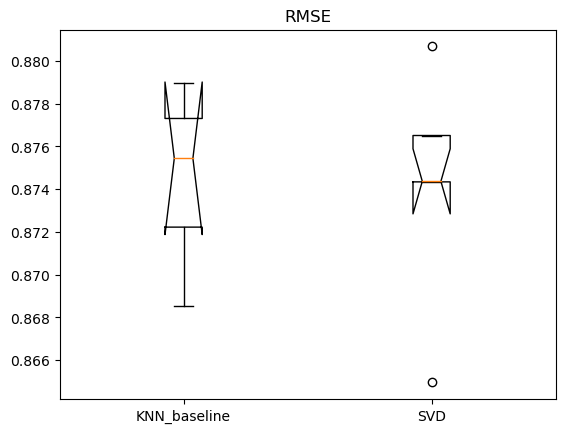

In [2]:
# Evaluate KNN_Baseline
n_folds = 5

reader = Reader()

whole_rating = Dataset.load_from_df(data_rating_new[['userId', 'movieId', 'rating']], reader)
my_own_rating = Dataset.load_from_df(my_rating[['userId', 'movieId', 'rating']], reader)

print('KNN baseline:', end=' ')
start = time.time()
res_KNNBaseline = cross_validate(prediction_algorithms.KNNBaseline(), whole_rating, cv=n_folds, n_jobs=-1)
end = time.time()
print('OK')
CT_KNNBaseline = (end - start)/n_folds

res_rmse_KNN_df = pd.DataFrame([res_KNNBaseline['test_rmse']])
res_rmse_KNN_df = res_rmse_KNN_df.T

models = ['KNN_baseline']
res_rmse_KNN_df.columns = models


res_ct_KNN_df = pd.DataFrame({'CT':[CT_KNNBaseline]})
res_ct_KNN_df.index = models

print("\nmean RMSE results:")
print(round(res_rmse_KNN_df.mean(), 3))
print("\nmean computation times:")
print(round(res_ct_KNN_df, 2))

print('-----------------------------------------------------------')

# Evaluating SVD and get rmse
print('SVD:', end=' ')
start = time.time()
res_SVD = cross_validate(prediction_algorithms.matrix_factorization.SVD(), whole_rating, cv=n_folds, n_jobs=-1)
end = time.time()
CT_SVD = (end - start)/n_folds
print('OK')

res_rmse_SVD_df = pd.DataFrame([res_SVD['test_rmse']])
res_rmse_SVD_df = res_rmse_SVD_df.T
models = ['SVD']
res_rmse_SVD_df.columns = models

res_ct_SVD_df = pd.DataFrame({'CT':[CT_SVD]})
res_ct_SVD_df.index = models

print("\nmean results:")
print(round(res_rmse_SVD_df.mean(), 3))
print("\n\nmean computation times:")
print(round(res_ct_SVD_df, 2))

print('-----------------------------------------------------------')

# Draw boxline of two models
res_rmse_KNN_SVD = pd.concat([res_rmse_KNN_df, res_rmse_SVD_df], axis=1)
fig, axs = plt.subplots()
axs.boxplot(res_rmse_KNN_SVD, notch=True, labels=res_rmse_KNN_SVD.columns)
axs.set_title('RMSE')
plt.show()

#### (c) Compute the 15 best recommendations you can get for each system.

In [3]:
# Use my rating as train dataset to train the algorithme
train_data = my_own_rating.build_full_trainset()

# Use the rating
test_data = Dataset.load_from_df(data_rating[['userId', 'movieId', 'rating']], reader)
testset = [test_data.df.loc[i].to_numpy() for i in range(len(test_data.df))]


algo_KNNBaseline = prediction_algorithms.KNNBaseline(sim_options={'name': 'msd', 'user_based': True})
algo_SVD = prediction_algorithms.SVD()
algo_KNNBaseline.fit(train_data)
algo_SVD.fit(train_data)

# Make prediction with model trained
predict_KNNBaseline = algo_KNNBaseline.test(testset)
predict_SVD = algo_SVD.test(testset)

# Sort the result to get 15 top rating
predict_KNNBaseline_sort = sorted(predict_KNNBaseline, key=lambda x:(x[3]),reverse=True)
predict_SVD_sort = sorted(predict_SVD, key=lambda x:(x[3]),reverse=True)

# drop_duplicates
predict_KNN = []
predict_SVD = []
for i in predict_KNNBaseline_sort:
    if i[1] not in predict_KNN:
        predict_KNN.append(i[1])
        
for i in predict_SVD_sort:
    if i[1] not in predict_SVD:
        predict_SVD.append(i[1])
# Get recommandation from two recommand systemes
print('Recommander movie ID for KNN Baseline:')
for i in range(15):
    print(data_movie.loc[data_movie['movieId'] == predict_KNN[i]]['title'].values)

print('\nRecommander movie ID for SVD:')
for i in range(15):
    print(data_movie.loc[data_movie['movieId'] == predict_SVD[i]]['title'].values)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Recommander movie ID for KNN Baseline:
['Toy Story (1995)']
['Black Butler: Book of the Atlantic (2017)']
['Heat (1995)']
['Usual Suspects, The (1995)']
['Grumpier Old Men (1995)']
['Bungo Stray Dogs: Dead Apple (2018)']
['From Dusk Till Dawn (1996)']
['Bottle Rocket (1996)']
['Braveheart (1995)']
['Rob Roy (1995)']
['Canadian Bacon (1995)']
['Desperado (1995)']
['Billy Madison (1995)']
['Clerks (1994)']
['Dumb & Dumber (Dumb and Dumber) (1994)']

Recommander movie ID for SVD:
['Toy Story (1995)']
['Black Butler: Book of the Atlantic (2017)']
['Heat (1995)']
['Usual Suspects, The (1995)']
['Grumpier Old Men (1995)']
['From Dusk Till Dawn (1996)']
['Bottle Rocket (1996)']
['Braveheart (1995)']
['Rob Roy (1995)']
['Canadian Bacon (1995)']
['Desperado (1995)']
['Billy Madison (1995)']
['Clerks (1994)']
['Dumb & Dumber (Dumb and Dumber) (1994)']
['Ed Wood (1994)']


#### (d) Bonus question: do the same things as for question (b) and (c) but with the content based approache(s) of Execise 1.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
data_movie['genres'] = data_movie['genres'].replace('-','_')
data_movie['genres'] = data_movie['genres'].replace('(no genres listed)','no_listed')

# Get one-hot matrix of genres
count = CountVectorizer()
count_matrix = count.fit_transform(data_movie['genres'])

count_matrix_df = pd.DataFrame(count_matrix.toarray())
count_matrix_df.index = data_movie['movieId']
count_matrix_df.columns = count.get_feature_names_out()

# Merge my_rating with the genres
my_rating = pd.merge(my_rating, data_movie, on='movieId')
my_rating = pd.merge(my_rating, count_matrix_df, on='movieId')
my_rating = my_rating.drop(columns=['timestamp', 'genres', 'title'])

# Get my profile
rating = my_rating.loc[:,['rating']].to_numpy()
genres = my_rating.iloc[:,3:]
# movieID = my_rating.loc[:,['movieId']]
weight_genre_matrix = genres.mul(rating)
user_me_profile = weight_genre_matrix.sum(axis=0)
user_me_profile = user_me_profile / user_me_profile.sum()
user_me_profile = pd.DataFrame(user_me_profile).sort_values(by=[0],ascending=False)

# Get prediction of movies
rate_me_predict = (count_matrix_df.dot(user_me_profile).rename(columns={0:'rating'})*4.5+0.5).sort_values(by=['rating'], ascending = False).iloc[0:15].reset_index()
rate_me_predict = pd.merge(rate_me_predict, data_movie, on='movieId').drop(['genres'], axis=1)
rate_me_predict

         action  adventure  animation  children  comedy  crime  documentary  \
movieId                                                                       
1             0          1          1         1       1      0            0   
2             0          1          0         1       0      0            0   
3             0          0          0         0       1      0            0   
4             0          0          0         0       1      0            0   
5             0          0          0         0       1      0            0   
...         ...        ...        ...       ...     ...    ...          ...   
193581        1          0          1         0       1      0            0   
193583        0          0          1         0       1      0            0   
193585        0          0          0         0       0      0            0   
193587        1          0          1         0       0      0            0   
193609        0          0          0         0     

,movieId,rating,title
0,2987,3.714286,Who Framed Roger Rabbit? (1988)
1,26340,3.714286,"Twelve Tasks of Asterix, The (Les douze travau..."
2,108932,3.714286,The Lego Movie (2014)
3,51939,3.714286,TMNT (Teenage Mutant Ninja Turtles) (2007)
4,52462,3.642857,Aqua Teen Hunger Force Colon Movie Film for Th...
5,4719,3.642857,Osmosis Jones (2001)
6,8253,3.500000,Lupin III: The Castle Of Cagliostro (Rupan san...
7,62956,3.428571,Futurama: Bender's Game (2008)
8,83349,3.285714,"Green Hornet, The (2011)"
9,81132,3.285714,Rubber (2010)
